In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 读取数据
df = pd.read_csv('../datasets/ETTh1.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df = df.iloc[0:24*30*12]


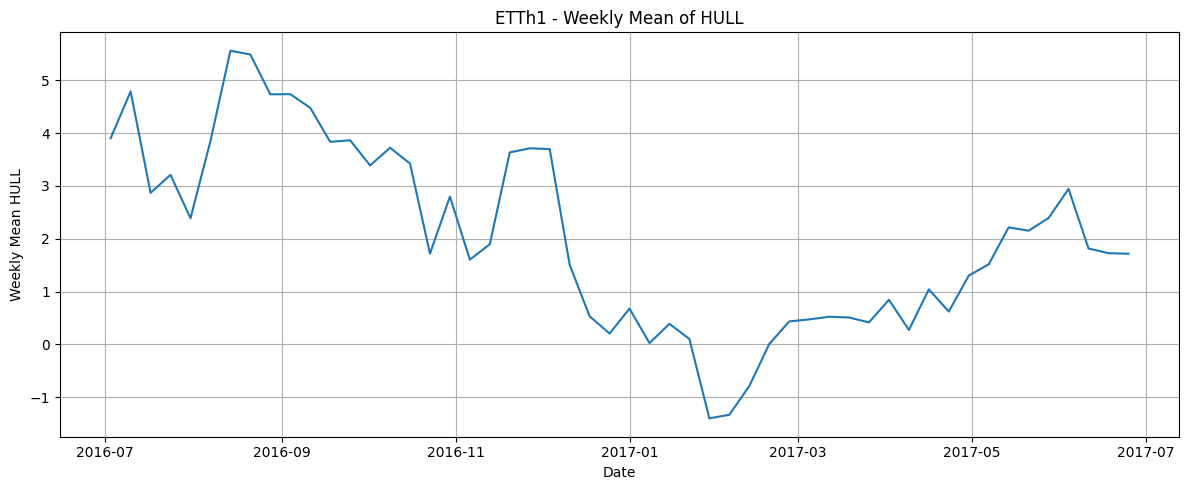

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def show_weekly_mean(df, target):
    # 2. 按每周重采样并求均值
    weekly_mean = df[target].resample('W').mean()

    # 3. 可视化
    plt.figure(figsize=(12, 5))
    plt.plot(weekly_mean)
    plt.title('ETTh1 - Weekly Mean of {}'.format(target))
    plt.xlabel('Date')
    plt.ylabel('Weekly Mean {}'.format(target))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

show_weekly_mean(df, 'HULL')


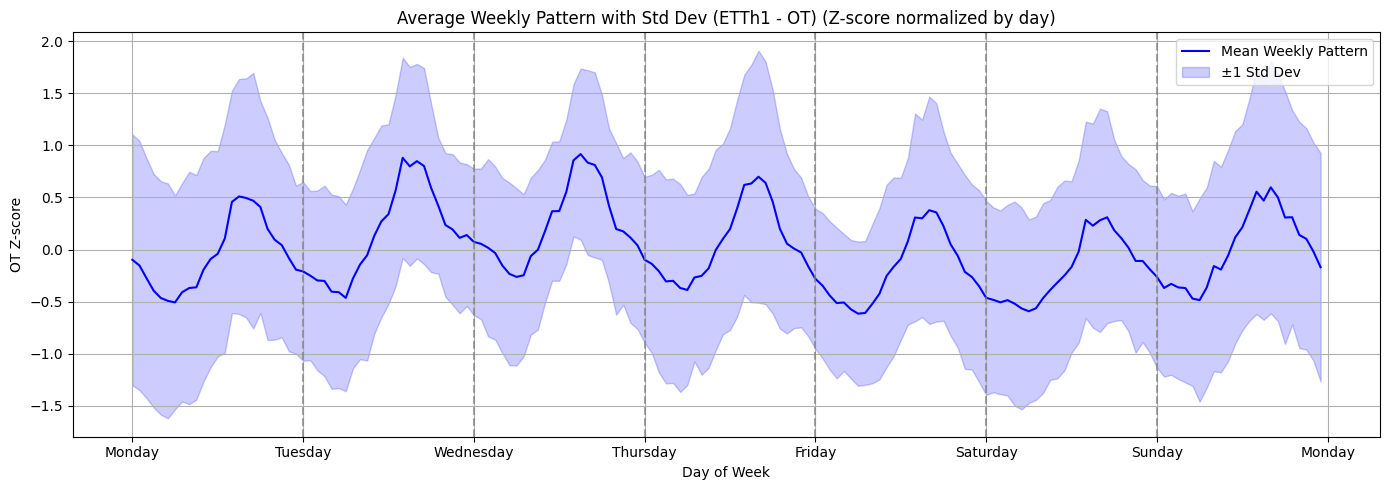

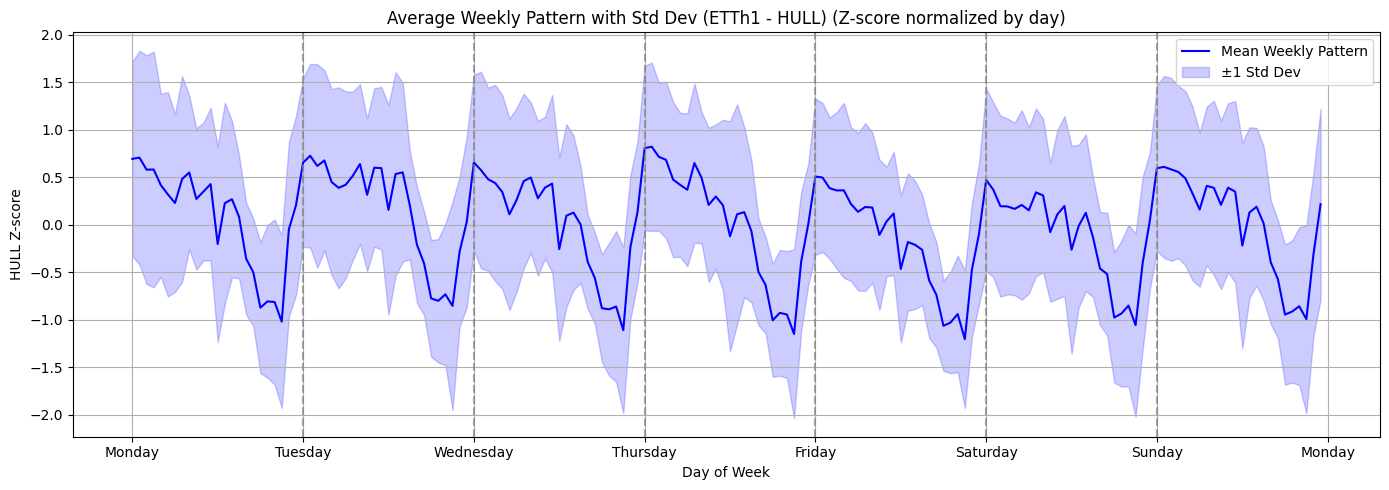

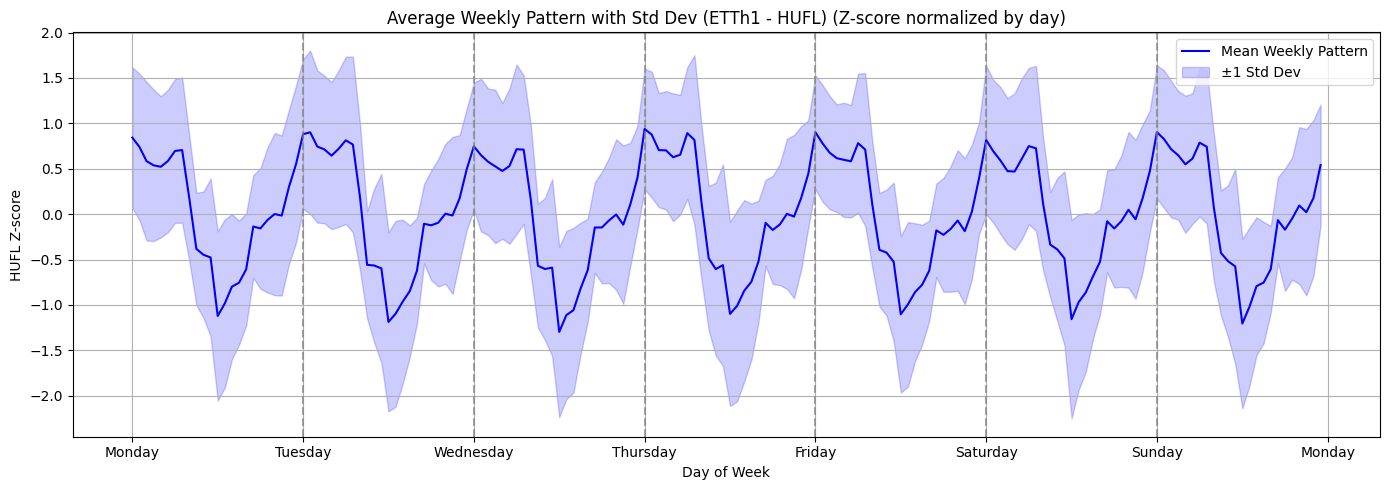

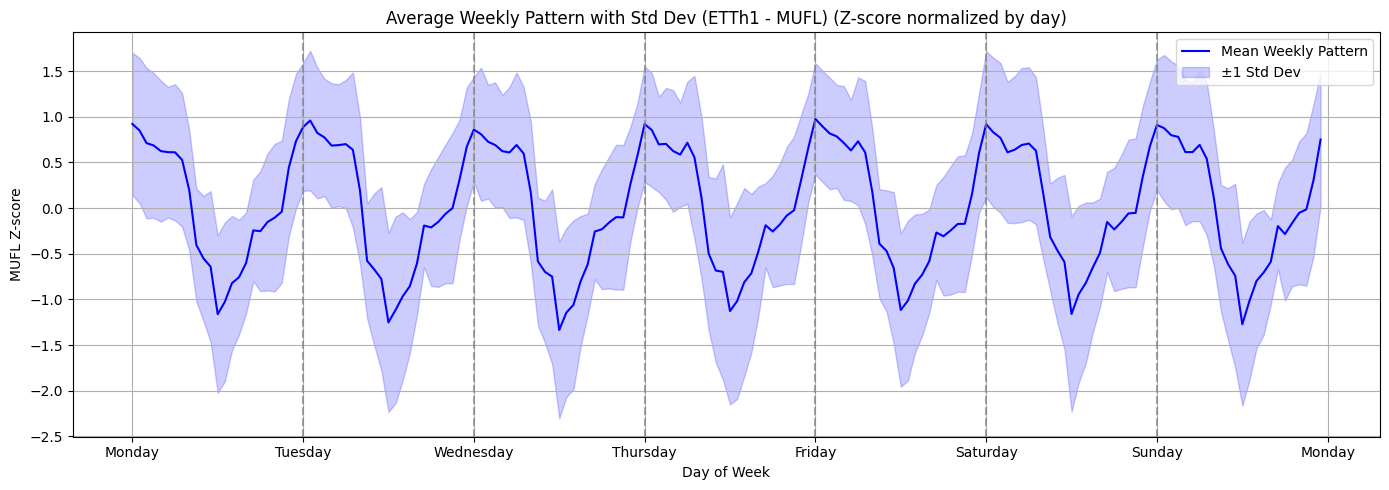

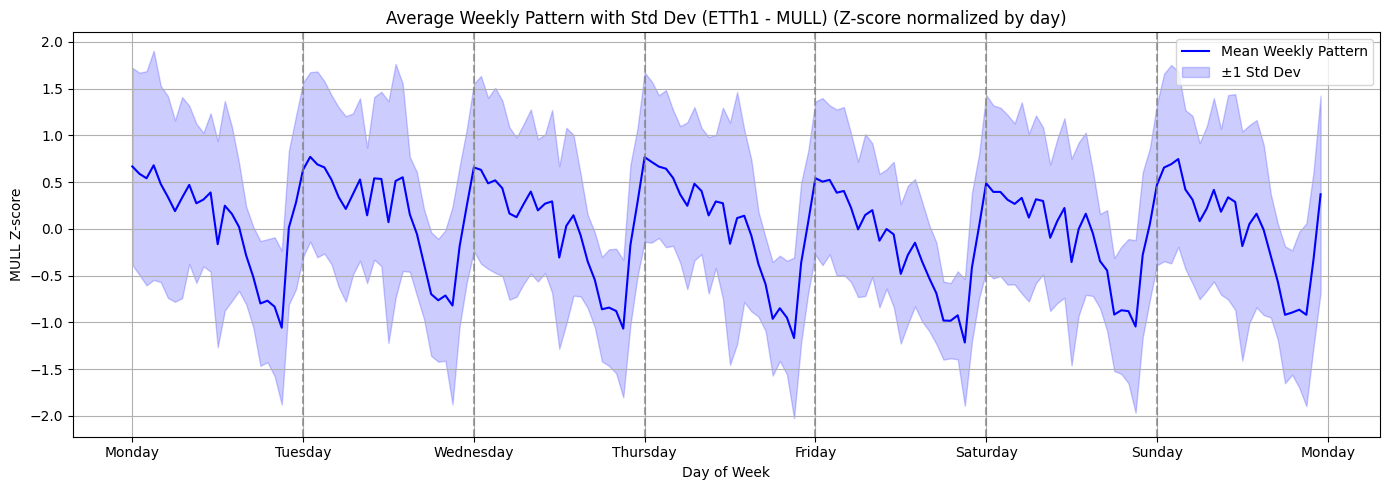

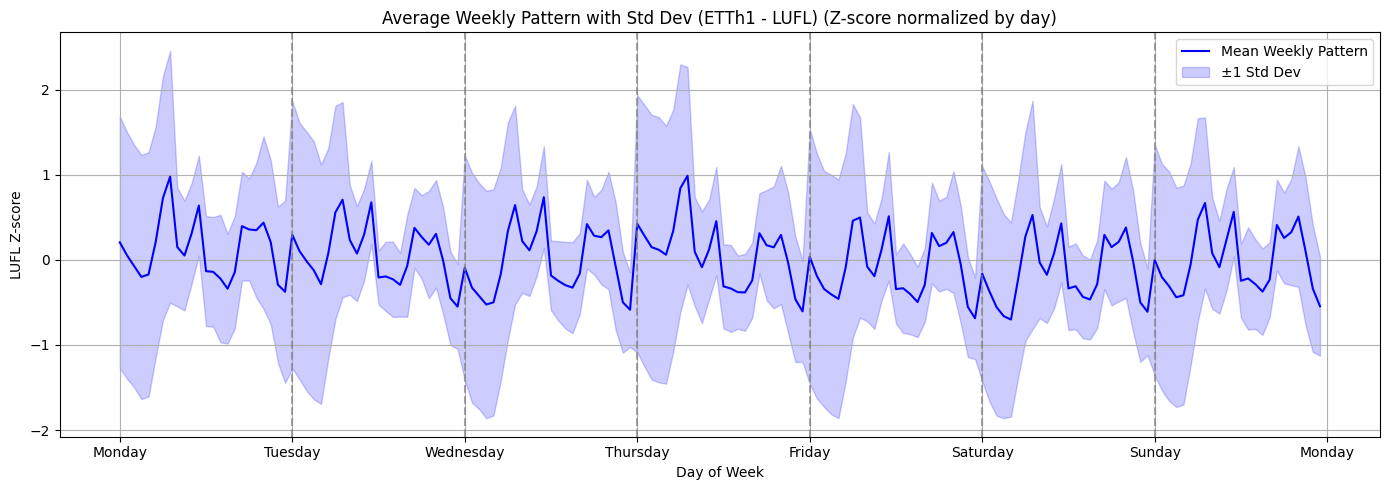

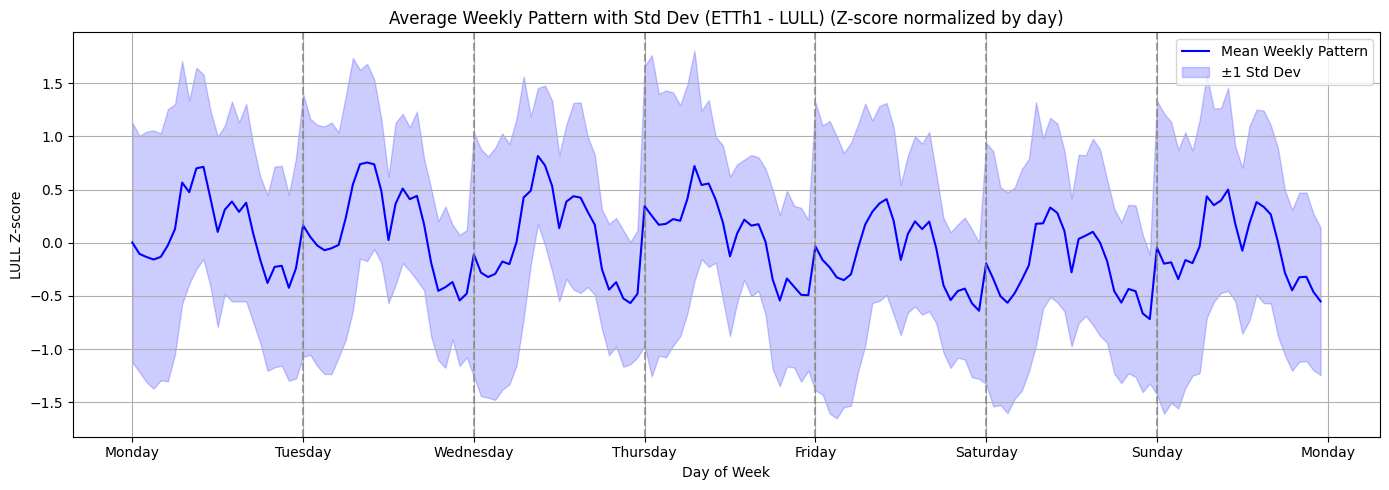

In [37]:
def show_weekly_pattern(df, target, normalize_by_week=True):
    ot = df[target].values

    points_per_week = 168  # 7 days × 24 hours
    hours_per_day = 24
    num_weeks = len(ot) // points_per_week
    ot = ot[:num_weeks * points_per_week]  # truncate to complete weeks

    # Reshape to [weeks, 168 points per week]
    weekly_matrix = ot.reshape(num_weeks, points_per_week)
    
    weekly_means = weekly_matrix.mean(axis=1, keepdims=True)
    weekly_stds = weekly_matrix.std(axis=1, keepdims=True) + 1e-6
    weekly_norm = (weekly_matrix - weekly_means) / weekly_stds

    if normalize_by_week:
        mean_weekly_pattern = weekly_norm.mean(axis=0)
        std_weekly_pattern = weekly_norm.std(axis=0)
    else:
        # Calculate mean and std dev at each hour of the week
        mean_weekly_pattern = weekly_matrix.mean(axis=0)
        std_weekly_pattern = weekly_matrix.std(axis=0)
    
    # Visualization
    plt.figure(figsize=(14, 5))
    
    # Create day labels
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Create x-axis tick positions and labels
    tick_positions = [i * hours_per_day for i in range(8)]  # Start of each day + end
    tick_labels = days + ['Monday']  # Add Monday again to complete the cycle
    
    plt.plot(mean_weekly_pattern, label='Mean Weekly Pattern', color='blue')
    plt.fill_between(range(len(mean_weekly_pattern)),
                    mean_weekly_pattern - std_weekly_pattern,
                    mean_weekly_pattern + std_weekly_pattern,
                    color='blue', alpha=0.2, label='±1 Std Dev')
    
    # Set x-axis ticks and labels
    plt.xticks(tick_positions, tick_labels)
    
    # Add vertical lines to separate days
    for i in range(1, 7):
        plt.axvline(x=i*hours_per_day, color='gray', linestyle='--', alpha=0.7)
    
    title_suffix = " (Z-score normalized by day)" if normalize_by_week else ""
    plt.title(f'Average Weekly Pattern with Std Dev (ETTh1 - {target}){title_suffix}')
    plt.xlabel('Day of Week')
    plt.ylabel(f'{target} Value' if not normalize_by_week else f'{target} Z-score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
show_weekly_pattern(df, 'OT')
show_weekly_pattern(df, 'HULL')
show_weekly_pattern(df, 'HUFL')
show_weekly_pattern(df, 'MUFL')
show_weekly_pattern(df, 'MULL')
show_weekly_pattern(df, 'LUFL')
show_weekly_pattern(df, 'LULL')

In [82]:
class WeeklyPattern:
    def __init__(self, points_per_week=168, normalize_by_week=False):
        self.points_per_week = points_per_week
        self.normalize_by_week = normalize_by_week
        self.mean_pattern = None  # [points_per_week, D]
        self.std_pattern = None   # [points_per_week, D]

    def fit(self, data):  # data: [N, D]
        N, D = data.shape
        num_weeks = N // self.points_per_week
        data = data[:num_weeks * self.points_per_week]  # truncate to full weeks
        weekly = data.reshape(num_weeks, self.points_per_week, D)  # [W, points_per_week, D]

        if self.normalize_by_week:
            # 按周归一化
            means = weekly.mean(axis=1, keepdims=True)  # [W, 1, D]
            stds = weekly.std(axis=1, keepdims=True) + 1e-6  # [W, 1, D]
            norm_weekly = (weekly - means) / stds
            self.mean_pattern = norm_weekly.mean(axis=0)  # [points_per_week, D]
            self.std_pattern = norm_weekly.std(axis=0)    # [points_per_week, D]
        else:
            # 全部按位置计算均值与方差
            self.mean_pattern = weekly.mean(axis=0)  # [points_per_week, D]
            self.std_pattern = weekly.std(axis=0)    # [points_per_week, D]

    # 可视化
    def plot(self, title='Weekly Pattern'):
        D = self.mean_pattern.shape[1]
        for d in range(D):
            plt.figure(figsize=(14, 5))
            plt.plot(self.mean_pattern[:, d], label='Mean Weekly Pattern', color='blue')
            plt.fill_between(range(len(self.mean_pattern)),
                             self.mean_pattern[:, d] - self.std_pattern[:, d],
                             self.mean_pattern[:, d] + self.std_pattern[:, d],
                             color='blue', alpha=0.2, label='±1 Std Dev')

            # Create day labels
            days = ['0', '1', '2', '3', '4', '5', '6', '7']

            # Create x-axis tick positions and labels
            tick_positions = [i * 24 for i in range(8)]  # Start of each day + end
            tick_labels = days

            # Set x-axis ticks and labels
            plt.xticks(tick_positions, tick_labels)
            
            # Add vertical lines to separate days
            for i in range(1, 7):
                plt.axvline(x=i*24, color='gray', linestyle='--', alpha=0.7)
            
            plt.title(title)
            plt.xlabel('Day of Week, dimension {}'.format(d))
            plt.ylabel('Z-score' if self.normalize_by_week else 'Value')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    def get_pattern(self, start_idx, end_index):
        """
        [start_idx, end_index) -> [end_index - start_idx, D]
        """
        start_b, start_i = start_idx // self.points_per_week, start_idx % self.points_per_week
        end_b, end_i = end_index // self.points_per_week, end_index % self.points_per_week
        if start_b == end_b:
            return self.mean_pattern[start_i:end_i]
        elif start_b + 1 == end_b:
            pattern = np.concatenate([self.mean_pattern[start_i:], self.mean_pattern[:end_i]], axis=0)
            return pattern
        else:
            repeat = end_b - start_b - 1
            start_part = self.mean_pattern[start_i:]
            middle_part = np.tile(self.mean_pattern, (repeat, 1))
            end_part = self.mean_pattern[:end_i]
            pattern = np.concatenate([start_part, middle_part, end_part], axis=0)
            return pattern

    def transform(self, data, start_idx, end_index):
        """
        data: [L, D]
        L = end_index - start_idx
        """
        assert data.shape[0] == end_index - start_idx
        pat = self.get_pattern(start_idx, end_index)
        return data - pat
    def inverse_transform(self, data, start_idx, end_index):
        """
        data: [L, D]
        L = end_index - start_idx
        """
        assert data.shape[0] == end_index - start_idx
        pat = self.get_pattern(start_idx, end_index)
        return data + pat

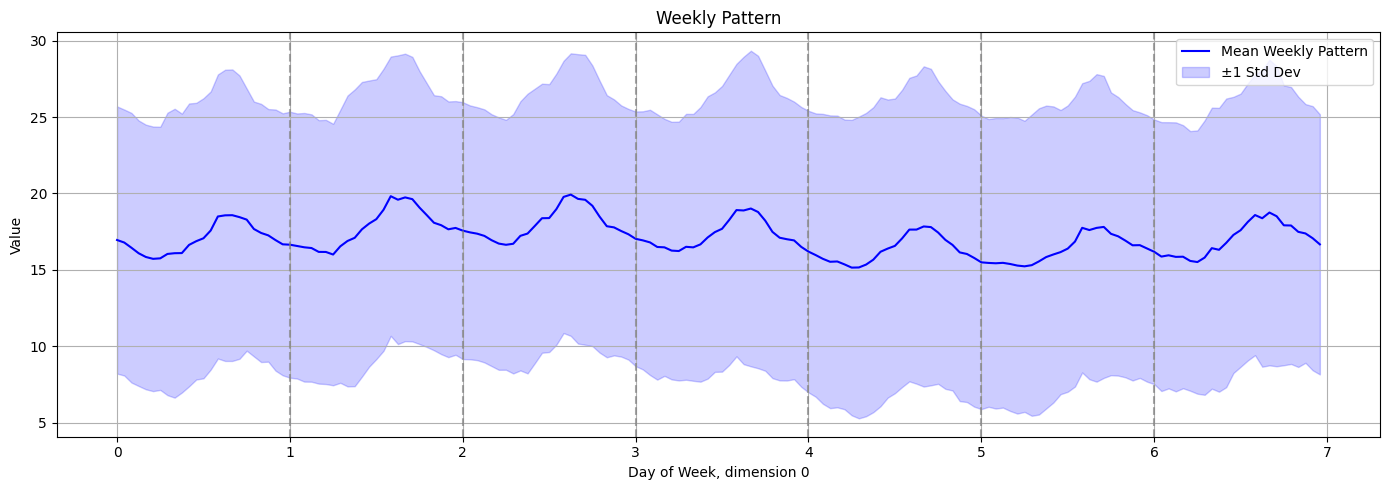

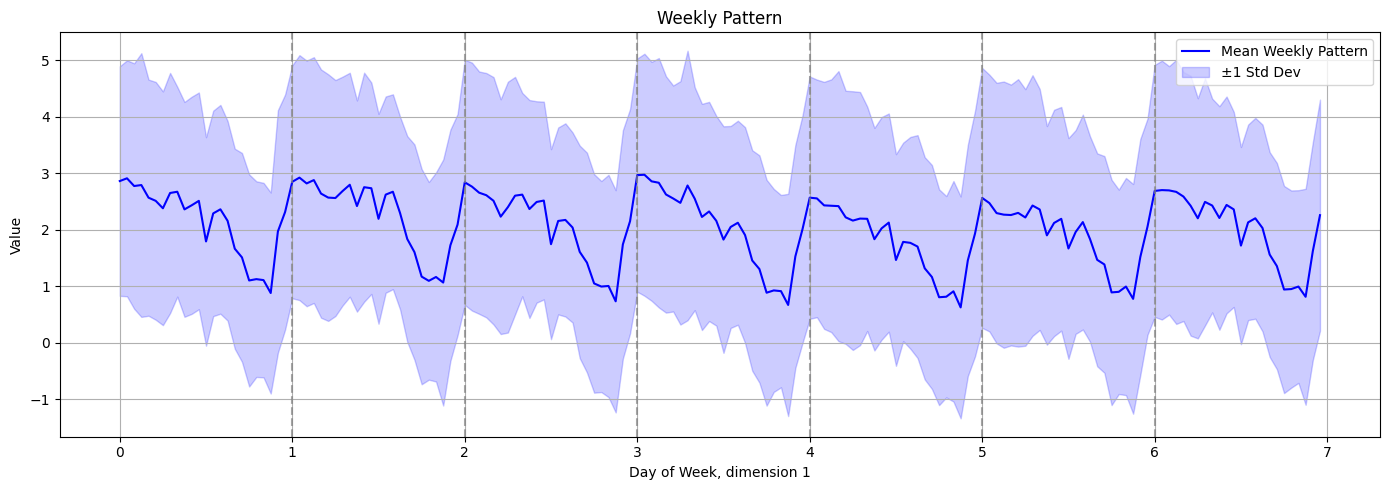

In [83]:
pattern = WeeklyPattern()
pattern.fit(df[['OT', 'HULL']].values)
pattern.plot()


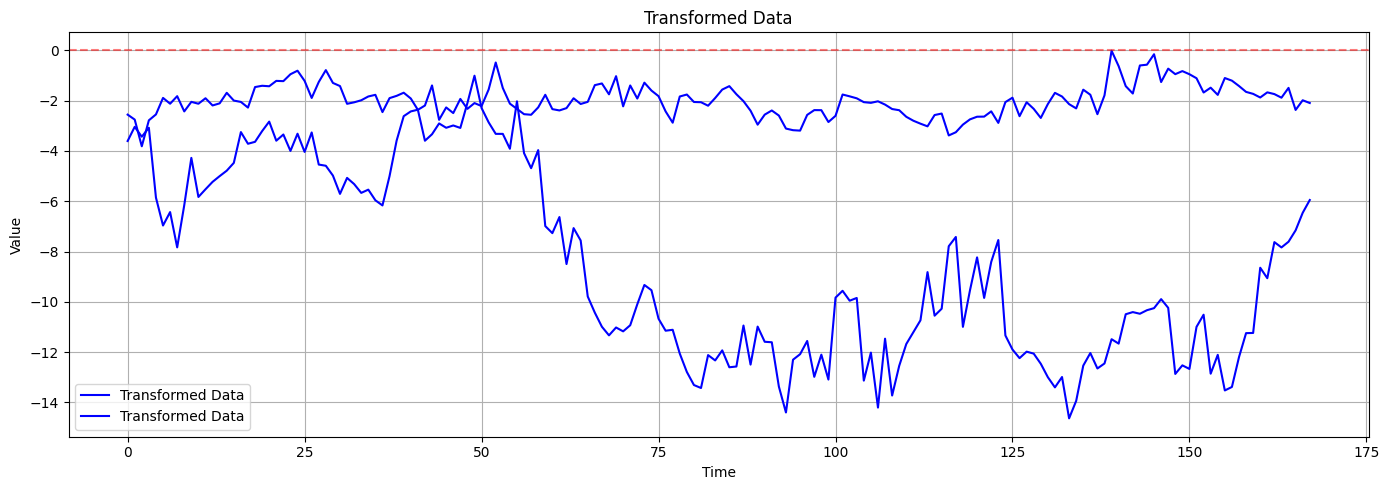

In [85]:
test_data = df[['OT', 'HULL']].values
start_idx = 4444
end_idx = start_idx + 168
test_data = test_data[start_idx:end_idx]
# print(test_data)
transformed_data = pattern.transform(test_data, start_idx, end_idx)
# print(transformed_data)
plt.figure(figsize=(14, 5))
plt.plot(transformed_data, label='Transformed Data', color='blue')
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.title('Transformed Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
